## Implementing Various Schroeder Reverbs
#### Annie Chu | October 18, 2021
Implementing multiple schroeder reverb algorithms

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure

#### Feedback Comb & All Pass Filters via Difference Equations

In [2]:
# creating feedback comb filter
def comb(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = x_n[i]
        else:
            y_n[i] = x_n[i] + g*y_n[i-d]
    return y_n

In [3]:
#testing comb
x1 = np.array([1.0, 0.1, -0.1])

y1 = comb(x1, 0.5, 1)
y2 = comb(x1, 0.5, 1)

print(y1)
print(y1+y2)

[1.  0.6 0.2]
[2.  1.2 0.4]


In [4]:
# creating all pass filter
def allpass(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = g*x_n[i]
        else:
            y_n[i] = g*x_n[i] + x_n[i-d] - g*y_n[i-d]
    return y_n

In [5]:
#testing all pass
x1 = np.array([1.0, 0.1, -0.1])

allpass(x1, 0.5, 1)

array([ 0.5 ,  0.8 , -0.35])

In [39]:
# creating lowpass feedback comb filter (Schroeder-Moorer)
def lp_comb(x_n, g, d, sg):
    # x_n is numpy array of initial samples
    # sg is secondary gain
    y_n = np.zeros(len(x_n));
    for i in range(len(x_n)):
        if i-d < 0:
            y_n[i] = x_n[i]
        else:
            y_n[i] = x_n[i] - g*x_n[i-1] + g*y_n[i-1] + sg*(1-g)*y_n[i-d]
    return y_n

In [37]:
#testing lp_comb
x1 = np.array([1.0, 0.1, -0.1])

y1 = lp_comb(x1, 0.5, 1, 0.7)
y2 = lp_comb(x1, 0.5, 1, 0.7)

print(y1)
print(y1+y2)

[1.     0.45   0.2325]
[2.    0.9   0.465]


### Creating Reverb Class

In [6]:
class Schroeder:
    kind = 'schroeder'
    
    def __init__(self, name, gc, dc, gap, dap, gx):
        self.name = name
#         self.gc1 = gc[0]
#         self.gc2 = gc[1]
#         self.gc3 = gc[2]
#         self.gc4 = gc[3]
#         self.dc1 = dc[0]
#         self.dc2 = dc[1]
#         self.dc3 = dc[2]
#         self.dc4 = dc[3]
#         self.gap1 = gap[0]
#         self.gap2 = gap[1]
#         self.gap3 = gap[2]
#         self.dap1 = dap[0]
#         self.dap2 = dap[1]
#         self.dap3 = dap[2]
        
        self.gc = gc
        self.dc = dc
        self.gap = gap
        self.dap = dap
    
        self.gx = gx
        self.x = 0
        self.yc_out = 0
        self.yap3 = 0
        
    def scale_delays(self):
        s_comb_d = (self.scale_fs/44100)*np.array(self.dc)
        s_ap_d = (self.scale_fs/44100)*np.array(self.dap)
        return s_comb_d, s_ap_d
    
    
    def apply_reverb(self, ch):
        if ch = "left":
            chan = self.x[:,0]
        else:
            chan = self.x[:,1]
        yc1 = comb(chan, self.gc[0], self.dc[0]) 
        yc2 = comb(chan, self.gc[1], self.dc[1])
        yc3 = comb(chan, self.gc[2], self.dc[2])
        yc4 = comb(chan, self.gc[3], self.dc[3])

        yc_out = yc1 + yc2 + yc3 + yc4

        yap1 = allpass(yc_out, self.gap[0], self.dap[0])
        yap2 = allpass(yap1, self.gap[1], self.dap[1])
        yap3 = allpass(yap2, self.gap[2], self.dap[2])

        y_final = yap3 + (self.gx*chan)
        return y_final
    
    def raw_mix(self):
        Lchan, Lyap_out, Lyap_test, Lyc_out_test, Lyc = self.apply_reverb("left")
        Rchan, Ryap_out, Ryap_test, Ryc_out_test, Ryc = self.apply_reverb("right")
        lMix_out = Lyap_out  + (self.gx*Lchan) #SHOULD BE FLOATS
        rMix_out = Ryap_out  + (self.gx*Rchan) 
        
        return lMix_out, rMix_out
    
    def norm_mix(self):
        Lmix, Rmix = self.raw_mix()
        Lmix_norm = np.int16(Lmix/np.max(np.abs(Lmix)) * 32767)
        Rmix_norm = np.int16(Rmix/np.max(np.abs(Rmix)) * 32767)
        return Lmix_norm, Rmix_norm
    
    def out_mix(self):
        Lmix_norm, Rmix_norm = self.norm_mix()
        out_mix = np.stack((Lmix_norm, Rmix_norm), axis=-1)
        return out_mix

In [7]:
x = np.array([1.0, 0.1, -0.1])

SATREV = Schroeder(
   'SATREV', 
   [0.805, 0.827, 0.783, 0.764], #gc
   [901, 778, 1011, 1123], #dc
   [0.7, 0.7, 0.7], #g
   [125, 42, 12], #dap
   0.7 #gx
)

In [38]:
print(SATREV.kind)
print(SATREV.dc1, SATREV.dc2, SATREV.dc3, SATREV.dc4)
print(type(SATREV.gx))

schroeder
901 778 1011 1123
<class 'float'>


In [9]:
SATREV.x = x

In [10]:
SATREV.rev()

array([ 2.072 ,  0.2072, -0.2072])

In [12]:
x = np.array([1.0, 0.1, -0.1])

JCREV = Schroeder(
    'JCREV', 
    [0.742, 0.733, 0.715, 0.697], 
    [4799, 4999, 5399, 5801], 
    [0.7, 0.7, 0.7], 
    [1051, 337, 113], 
    0.7
)

In [15]:
print(JCREV.kind)
print(JCREV.dc1, JCREV.dc2, JCREV.dc3, JCREV.dc4)
print(type(JCREV.gx))

schroeder
4799 4999 5399 5801
<class 'float'>


In [16]:
JCREV.x = x
JCREV.rev()

array([ 2.072 ,  0.2072, -0.2072])

In [ ]:
class Freeverb:
    kind = 'freeverb'
    
    def __init__(self, name, gc, sgc, dc, gap, dap, gx):
        self.name = name
        self.gc = gc
        self.sgc = sgc
        self.dc1 = dc[0]
        self.dc2 = dc[1]
        self.dc3 = dc[2]
        self.dc4 = dc[3]
        self.dc5 = dc[4]
        self.dc6 = dc[5]
        self.dc7 = dc[6]
        self.dc8 = dc[7]
        self.gap = gap
        self.dap1 = dap[0]
        self.dap2 = dap[1]
        self.dap3 = dap[2]
        self.dap4 = dap[3]
        self.gx = gx
        self.x = 0
        self.yc_out = 0
        self.yap3 = 0
        
    def rev(self):
        yc1 = lp_comb(self.x, self.gc1, self.dc1, self.sgc1) 
        yc2 = lp_comb(self.x, self.gc2, self.dc2, self.sgc2)
        yc3 = lp_comb(self.x, self.gc3, self.dc3, self.sgc3)
        yc4 = lp_comb(self.x, self.gc4, self.dc4, self.sgc4)

        yc_out = yc1 + yc2 + yc3 + yc4

        yap1 = allpass(yc_out, self.gap1, self.dap1)
        yap2 = allpass(yap1, self.gap2, self.dap2)
        yap3 = allpass(yap2, self.gap3, self.dap3)

        y_final = yap3 + (self.gx*self.x)
        return y_final

==============================



==============================

In [17]:
audiofile = "/Users/anniechu/Desktop/CantinaBand3.wav"
fs, cb_data = wavfile.read(audiofile)

In [18]:
#checking cb_data contents
print(f".Wav Contents = {cb_data}")
print(f".Wav Shape = {cb_data.shape}")
length = cb_data.shape[0] / fs
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs} Hz")


.Wav Contents = [   3    7    0 ...  -12 -427 -227]
.Wav Shape = (66150,)
.Wav Length = 3.0s
Sampling Rate= 22050 Hz


In [20]:
#playing original cantina band .wav file
wave_obj = sa.WaveObject.from_wave_file(audiofile)
play_obj = wave_obj.play()
#play_obj.wait_done()

In [21]:
play_obj.stop()

In [22]:
#adding reverb to cantina band .wav file
SATREV.x = cb_data
rv_cb = SATREV.rev()

#checking original vs reverbed array
print(f"ORIGINAL = {len(cb_data)} | {cb_data}")
print(f"REVERBED = {len(rv_cb)} | {rv_cb}")

ORIGINAL = 66150 | [   3    7    0 ...  -12 -427 -227]
REVERBED = 66150 | [    6.216         14.504          0.         ...  2553.81846747
   381.28899904 -1742.61019732]


In [23]:
#normalizing & converting for analogue output (dac)
rv_cb1=np.int16(rv_cb/np.max(np.abs(rv_cb)) * 32767)
cb_data1 =np.int16(cb_data/np.max(np.abs(cb_data)) * 32767)

print(rv_cb1)
print(cb_data1)

[    5    12     0 ...  2163   323 -1476]
[   10    25     0 ...   -43 -1554  -826]


#### Audio Comparison: Original vs SATREV version

In [24]:
#original
play_obj = sa.play_buffer(cb_data1, 1, 2, fs)

In [25]:
play_obj.stop()

In [27]:
#reverbed
play_obj = sa.play_buffer(rv_cb1, 1, 2, fs)

In [28]:
play_obj.stop()

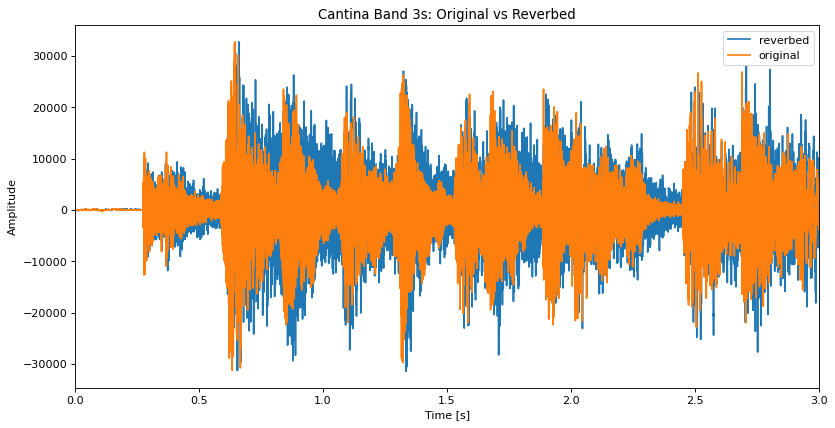

In [29]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, cb_data.shape[0])
plt.plot(time, rv_cb1, label="reverbed")
plt.plot(time, cb_data1, label="original")
plt.xlim(0, 3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Cantina Band 3s: Original vs Reverbed")
plt.show()

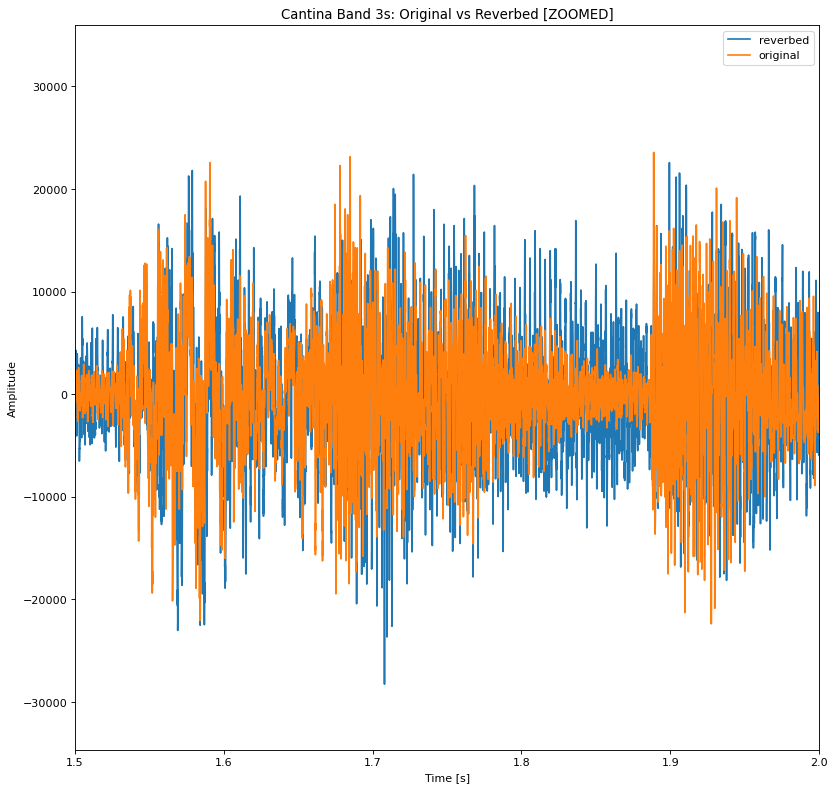

In [33]:
figure(figsize=(12, 12), dpi=80)
time = np.linspace(0., length, cb_data.shape[0])
plt.plot(time, rv_cb1, label="reverbed")
plt.plot(time, cb_data1, label="original")
plt.xlim(1.5, 2)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Cantina Band 3s: Original vs Reverbed [ZOOMED]")
plt.show()